In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.utils.prune as prune

import pathlib
from collections import defaultdict
import matplotlib.pyplot as plt

from datasets import symbolic_1
from architectures.simlpe_mlp import SimpleMLP
from common import torch_utils

In [2]:
epochs = 2000
pruning_levels = 5
pruning_rate = .1
lr = 0.005
model_shape = [symbolic_1.INPUT_DIM, 10, 4, 10, symbolic_1.OUTPUT_DIM]

In [35]:
def countZeroWeights(model):
    zeros = 0
    for param in model.parameters():
        if param is not None:
            torch.sum((param == 0)).item()
            zeros += torch.sum((param == 0).int()).data[0]
    return zeros

def count_model_params(model):
    return sum([p.numel() for p in model.parameters() if p is not None])

def pruning_stats(parameters_to_prune, stats_dict=None):
    if stats_dict is None: stats_dict = defaultdict(list)

    for i, (module, name) in enumerate(parameters_to_prune):
        zeros = torch.sum((module.weight != 0)).item()
        stats_dict[f"{i}-{name}"].append(zeros)
    return stats_dict

In [31]:
lr = 0.005
model_shape = [symbolic_1.INPUT_DIM, 10, 4, 10, symbolic_1.OUTPUT_DIM]

model = SimpleMLP(model_shape)
optim = torch.optim.SGD(model.parameters(), lr = lr)
loss_fn = torch.nn.MSELoss(reduction="mean")

In [32]:
pruning_levels = 5
pruning_rate = .2

n = count_model_params(model)
print(n)
for lvl in range(pruning_levels):
    num_prune = prune._compute_nparams_toprune(pruning_rate, n)
    n -= num_prune
    print(n)

166
133
106
85
68
54


https://discuss.pytorch.org/t/cant-reset-parameters-with-torch-nn-utils-prune/76115/4
https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#iterative-pruning

In [36]:
epochs = 2000

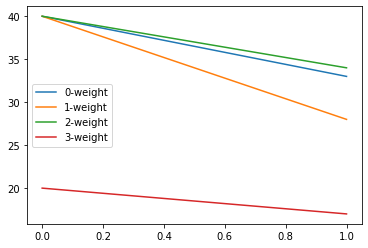

In [37]:
lr = 0.005
model_shape = [symbolic_1.INPUT_DIM, 10, 4, 10, symbolic_1.OUTPUT_DIM]

model = SimpleMLP(model_shape)
optim = torch.optim.SGD(model.parameters(), lr = lr)
loss_fn = torch.nn.MSELoss(reduction="mean")

stats_dict = None
loss = defaultdict(list)
modules = [m for m in model.modules if torch_utils.module_is_trainable(m)]

train_loader, test_loader = symbolic_1.get_dataloaders()
parameters_to_prune = [(module, 'weight') for module in modules]

stats_dict = pruning_stats(parameters_to_prune, stats_dict)

for step in range(epochs):
    eval_loss = torch_utils.evaluate(model, test_loader, loss_fn)
    train_loss = torch_utils.update(model, train_loader, optim, loss_fn)
    loss['eval'].append(eval_loss)
    loss['train'].append(train_loss)    

prune.global_unstructured(
    parameters_to_prune,
    prune.L1Unstructured,
    amount=pruning_rate,
)
parameters_to_prune = [(module, 'weight') for module in modules]
stats_dict = pruning_stats(parameters_to_prune, stats_dict)

for k, v in stats_dict.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

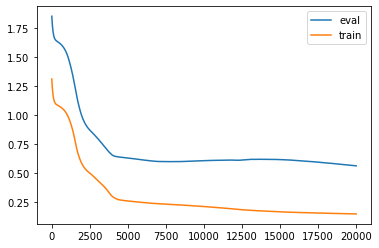

In [40]:
plt.plot(loss['eval'], label="eval")
plt.plot(loss['train'], label="train")
plt.legend()
plt.show()